# <center> Model building

In [27]:
import kaggle

In [28]:
kaggle

<module 'kaggle' from '/Users/maksymsuprunenko/anaconda3/lib/python3.7/site-packages/kaggle/__init__.py'>

I will use following models:
1. XGBoost
2. LightGBM
3. Stacking

Evaluation metric: MAPE

In [1]:
%store -r X_train
%store -r X_test

%store -r y_train
%store -r y_test

no stored variable y_test


In [4]:
import numpy as np
import pandas as pd 

import xgboost as xgb
from xgboost import plot_importance

import warnings
import matplotlib.pyplot as plt
%matplotlib inline 

from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# Initialize plotly
init_notebook_mode(connected=True)

from IPython.core.debugger import set_trace
from time import time

from tqdm import tqdm
tqdm.pandas(desc="")
warnings.filterwarnings("ignore")
import os

# SKLEARN

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, KFold
from scipy.stats import randint as sp_randint
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score

# LightGBM
from lightgbm import LGBMRegressor
import lightgbm as lgb

# Sklearn-pandas
from sklearn_pandas import CategoricalImputer, FunctionTransformer, DataFrameMapper

# Bayessian Optimization
from bayes_opt import BayesianOptimization
from hyperopt import hp
from hyperopt import fmin, tpe, space_eval
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# vecstack
from vecstack import stacking

Save model

In [22]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, **params)

xgb_model.fit(X_train, y_train)

XGBoostError: [22:48:53] src/objective/objective.cc:23: Unknown objective function reg:rmse
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000001a39bc2319 dmlc::LogMessageFatal::~LogMessageFatal() + 57
  [bt] (1) 2   libxgboost.dylib                    0x0000001a39c4874d xgboost::ObjFunction::Create(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&) + 541
  [bt] (2) 3   libxgboost.dylib                    0x0000001a39bc7891 xgboost::LearnerImpl::LazyInitModel() + 1409
  [bt] (3) 4   libxgboost.dylib                    0x0000001a39bdd06e XGBoosterUpdateOneIter + 158
  [bt] (4) 5   libffi.6.dylib                      0x0000000110ab2884 ffi_call_unix64 + 76
  [bt] (5) 6   ???                                 0x00007ffee08b9700 0x0 + 140732665665280



SyntaxError: can't use starred expression here (<ipython-input-26-9939f8d9eac5>, line 4)

In [23]:
params = {
    'n_estimators': 300,
    'eta': 0.01,
    'max_depth': 4,
    'early_stopping_rounds':30,
    'objective': 'reg:squarederror',
    'seed': 1
}

dtrain = xgb.DMatrix(X_train_val, label=y_train_val)
dvalid = xgb.DMatrix(X_test, label=y_test)

progress = dict()
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]

num_round = int(params['n_estimators'])

xgb_model = xgb.XGBRegressor(objective="reg:rmse", random_state=42)

xgb_model.fit(X, y)

y_pred = xgb_model.predict(X)


KeyboardInterrupt: 

In [33]:
mape_test_score = mape(gbm_model.predict(dvalid), y_test)
r2_test_score = r2_score(gbm_model.predict(dvalid), y_test)

print(f"mape_test_score: {mape_test_score}")
print(f"r2_test_score: {r2_test_score}")

mape_test_score: 54.73810577392578
r2_test_score: -36.41731700445793


In [32]:
mape_train_score = mape(gbm_model.predict(dtrain), y_train_val)
r2_train_score = r2_score(gbm_model.predict(dtrain), y_train_val)

print(f"mape_test_score: {mape_train_score}")
print(f"r2_test_score: {r2_train_score}")

mape_test_score: 45.931663513183594
r2_test_score: -8.49584083639348


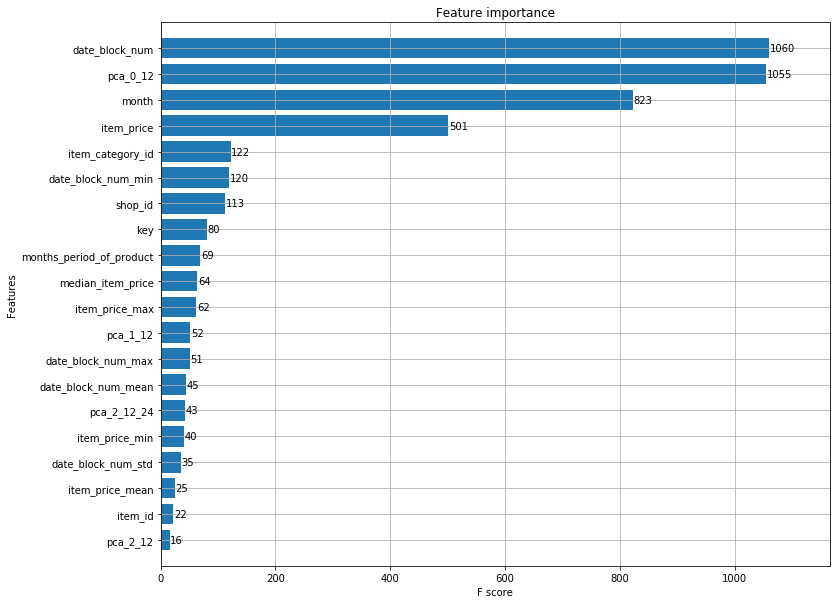

In [39]:
fig, ax = plt.subplots(figsize=(12,10))
xgb.plot_importance(gbm_model, max_num_features=20, height=0.8, ax=ax)
plt.show()

In [65]:
len(progress['eval']['rmse'])

300

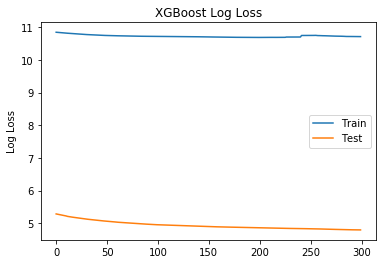

In [67]:
# make predictions for test data
y_pred = gbm_model.predict(dvalid)
predictions = np.round(y_pred)
# evaluate predictions
accuracy = mape(y_test, predictions)
# retrieve performance metrics
epochs = len(progress['eval']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, progress['eval']['rmse'], label='Train')
ax.plot(x_axis, progress['train']['rmse'], label='Test')
ax.legend()
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss')
plt.show()

In [16]:
cat_feats = ['shop_id', 'key', 'item_category_id', 'item_id', 'date_block_num', 
             'item_category_names_category_1_enc', 'item_category_names_category_2_enc']

lgbm = LGBMRegressor(
    boosting_type= 'gbdt',
    objective = 'rmse',
    metric = "rmse",
    max_depth = 7,
    n_estimators = 1000,
    colsample_bytree=0.7,
    min_child_weight = 300,
    reg_alpha = 1,
    reg_lambda = 1,
    random_state = 1,
)

lgbm.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train)], 
    verbose=10, 
    categorical_feature = cat_feats)

[10]	training's rmse: 0.853228
[20]	training's rmse: 0.733323
[30]	training's rmse: 0.689024
[40]	training's rmse: 0.665879
[50]	training's rmse: 0.655788
[60]	training's rmse: 0.645745
[70]	training's rmse: 0.637892
[80]	training's rmse: 0.633454
[90]	training's rmse: 0.628341
[100]	training's rmse: 0.625555
[110]	training's rmse: 0.622352
[120]	training's rmse: 0.618221
[130]	training's rmse: 0.614835
[140]	training's rmse: 0.611189
[150]	training's rmse: 0.608373
[160]	training's rmse: 0.605781
[170]	training's rmse: 0.604059
[180]	training's rmse: 0.602223
[190]	training's rmse: 0.6004
[200]	training's rmse: 0.59786
[210]	training's rmse: 0.596116
[220]	training's rmse: 0.594357
[230]	training's rmse: 0.592911
[240]	training's rmse: 0.591376
[250]	training's rmse: 0.589805
[260]	training's rmse: 0.588833
[270]	training's rmse: 0.587562
[280]	training's rmse: 0.586036
[290]	training's rmse: 0.584845
[300]	training's rmse: 0.583465
[310]	training's rmse: 0.581423
[320]	training's rms

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
              importance_type='split', learning_rate=0.1, max_depth=7,
              metric='rmse', min_child_samples=20, min_child_weight=300,
              min_split_gain=0.0, n_estimators=1000, n_jobs=-1, num_leaves=31,
              objective='rmse', random_state=1, reg_alpha=1, reg_lambda=1,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

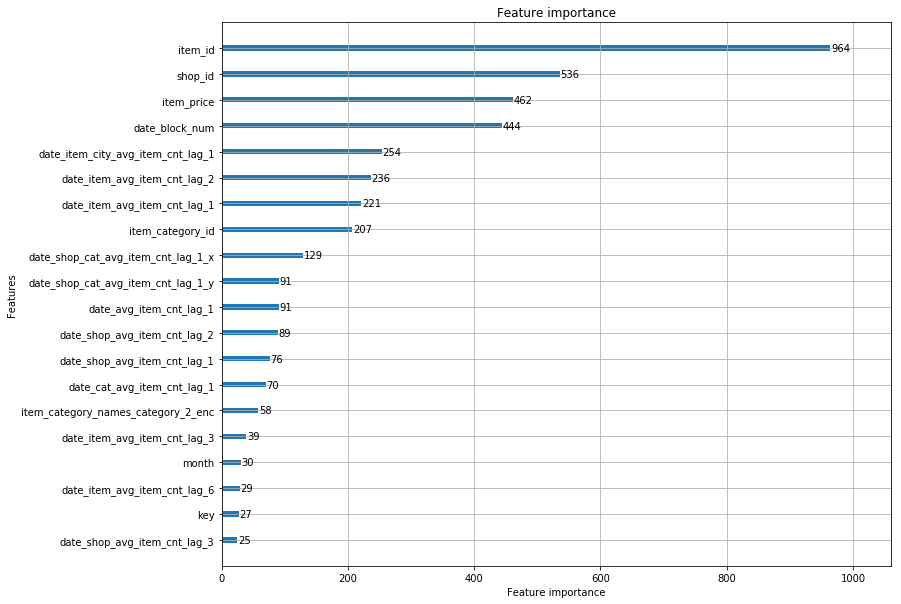

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
ax = lgb.plot_importance(lgbm, max_num_features=20, ax=ax)
plt.show()

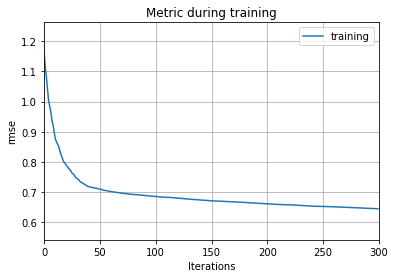

In [13]:
ax = lgb.plot_metric(lgbm)
plt.show()

In [18]:
import pandas as pd
import numpy as np

result = lgbm.predict(X_test)

submission = pd.DataFrame({
    "ID": np.arange(result.shape[0]), 
    "item_cnt_month": result
})

submission.to_csv('lgbm_submission.csv', index=False)

In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=2, random_state=1,n_estimators=1000)
regr.fit(X_train, y_train)

In [ ]:
import pandas as pd
import numpy as np

result = regr.predict(X_test)

submission = pd.DataFrame({
    "ID": np.arange(result.shape[0]), 
    "item_cnt_month": result
})

submission.to_csv('rf_submission.csv', index=False)

# <center> Ensembling

In [76]:
import pickle
models = [lgbm, xgb]
s1_train, s1_test = stacking(models,
                           pd.concat([X_train_val, ] ), y_train_val, X_test,
                           regression=True,
                           mode='oof_pred_bag',
                           random_state=25,
                           verbose=2
                          )

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [1]

model  0:     [LGBMRegressor]
    fold  0:  [0.73905428]
    fold  1:  [0.94454948]
    fold  2:  [0.90556172]
    fold  3:  [1.36783669]
    ----
    MEAN:     [0.98925054] + [0.23180145]
    FULL:     [0.98925054]



In [87]:
xgb_lev2 = xgb.XGBRegressor(learning_rate=0.04, 
                        n_estimators=900,
                        max_depth=3,
                        n_jobs=-1,
                        random_state=17
                       )

# Fit the 2nd level model on the output of level 1
xgb_lev2.fit(s1_train, y_train_val)

[20:31:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.04, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=900,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=17,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [88]:
%store xgb_lev2

Stored 'xgb_lev2' (XGBRegressor)
